═══════════════════════════════════════════════════════════════════════════════

CAREER PATH RECOMMENDATION USING REINFORCEMENT LEARNING & KNOWLEDGE GRAPHS
Complete Production-Ready Kaggle Notebook Code

═══════════════════════════════════════════════════════════════════════════════

For Indian Students (Post-12th Standard)
Target: Train DDQN model to recommend optimal career paths

Features:
- Load and preprocess Indian student dataset (2,000 profiles)
- Build career knowledge graph from trajectories
- Implement CareerEnvironment (custom RL environment)
- Train Dueling Double DQN agent
- Evaluate with multiple metrics
- Generate sample recommendations
- Save model for deployment

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from collections import deque
import random
import json
import pickle
import warnings
import os
warnings.filterwarnings('ignore')

In [2]:
# Set random seeds
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Device setup (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

Device: cuda
GPU: Tesla T4


In [3]:
# ═══════════════════════════════════════════════════════════════════════════════
# SECTION 1: LOAD & PREPROCESS DATA
# ═══════════════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("SECTION 1: LOADING AND PREPROCESSING DATASET")
print("="*80)

# Load dataset - Update path based on your Kaggle dataset
#df = pd.read_csv('/kaggle/input/YOUR-DATASET-NAME/indian_students_career_dataset_synthetic_2000.csv')
#df = pd.read_csv('/kaggle/input/indian-students-career-dataset-synthetic-2000')
# Check files inside dataset directory
print(os.listdir('/kaggle/input/indian-students-career-dataset-synthetic-2000'))
# Load CSV file
df = pd.read_csv('/kaggle/input/indian-students-career-dataset-synthetic-2000/indian_students_career_dataset_synthetic_2000.csv')
print(f"✓ Dataset loaded: {df.shape[0]} students × {df.shape[1]} features")

# Handle missing values
exam_columns = ['JEE_Main_percentile', 'JEE_Advanced_rank', 'NEET_percentile', 
                'NEET_rank', 'CUET_score']
for col in exam_columns:
    if col in df.columns:
        df[col] = df[col].fillna(-1)

print("✓ Handled missing values")

# Feature definitions
categorical_features = [
    'gender', 'state', 'urban_rural', 'family_income',
    '12th_stream', 'school_board', 'school_tier',
    'preferred_location', 'career_goal_timeline', 'work_preference', 'risk_tolerance'
]

numerical_features = [
    '10th_percentage', '12th_percentage',
    'logical_reasoning', 'quantitative_ability', 'verbal_ability',
    'abstract_reasoning', 'spatial_reasoning',
    'interest_technology', 'interest_healthcare', 'interest_business',
    'interest_creative_arts', 'interest_social_service', 'interest_research',
    'leadership', 'teamwork', 'creativity', 'analytical_thinking', 'communication',
    'budget_constraint_lakhs', 'volunteering_hours', 'num_certifications', 'num_projects'
]
numerical_features.extend(exam_columns)

# Encode categorical features
label_encoders = {}
df_encoded = df.copy()

for col in categorical_features:
    if col in df.columns:
        le = LabelEncoder()
        df_encoded[col + '_encoded'] = le.fit_transform(df[col])
        label_encoders[col] = le

# Normalize numerical features
scaler = MinMaxScaler()
df_encoded[numerical_features] = scaler.fit_transform(df[numerical_features])

print(f"✓ Encoded {len(categorical_features)} categorical features")
print(f"✓ Normalized {len(numerical_features)} numerical features")

# Career path encoding
career_columns = ['career_path_year1', 'career_year2', 'career_year3', 
                  'career_year4', 'career_year5']

all_careers = []
for col in career_columns:
    all_careers.extend(df[col].unique())
all_careers = list(set(all_careers))

career_to_id = {career: idx for idx, career in enumerate(all_careers)}
id_to_career = {idx: career for career, idx in career_to_id.items()}

for col in career_columns:
    df_encoded[col + '_id'] = df[col].map(career_to_id)

print(f"✓ Total unique careers: {len(all_careers)}")

# Create state vectors
def create_state_vector(row):
    state = []
    for col in categorical_features:
        if col in row.index:
            state.append(row[col + '_encoded'])
    for col in numerical_features:
        if col in row.index:
            state.append(row[col])
    return np.array(state, dtype=np.float32)

print("Creating state vectors...")
states = [create_state_vector(row) for _, row in df_encoded.iterrows()]
X = np.array(states)
print(f"✓ State matrix shape: {X.shape}")


SECTION 1: LOADING AND PREPROCESSING DATASET
['indian_students_career_dataset_synthetic_2000.csv']
✓ Dataset loaded: 2000 students × 48 features
✓ Handled missing values
✓ Encoded 11 categorical features
✓ Normalized 27 numerical features
✓ Total unique careers: 72
Creating state vectors...
✓ State matrix shape: (2000, 38)



SECTION 2: BUILDING KNOWLEDGE GRAPH
✓ Knowledge graph: 72 nodes, 188 edges

Top 10 Career Hubs:
  Junior Professional: 40 connections
  Entry Level: 40 connections
  Professional: 20 connections
  ML Engineer: 10 connections
  Data Scientist: 7 connections
  Electronics Engineering: 5 connections
  Bio-informatics: 5 connections
  Information Technology: 5 connections
  Computer Science Engineering: 5 connections
  Nursing: 5 connections


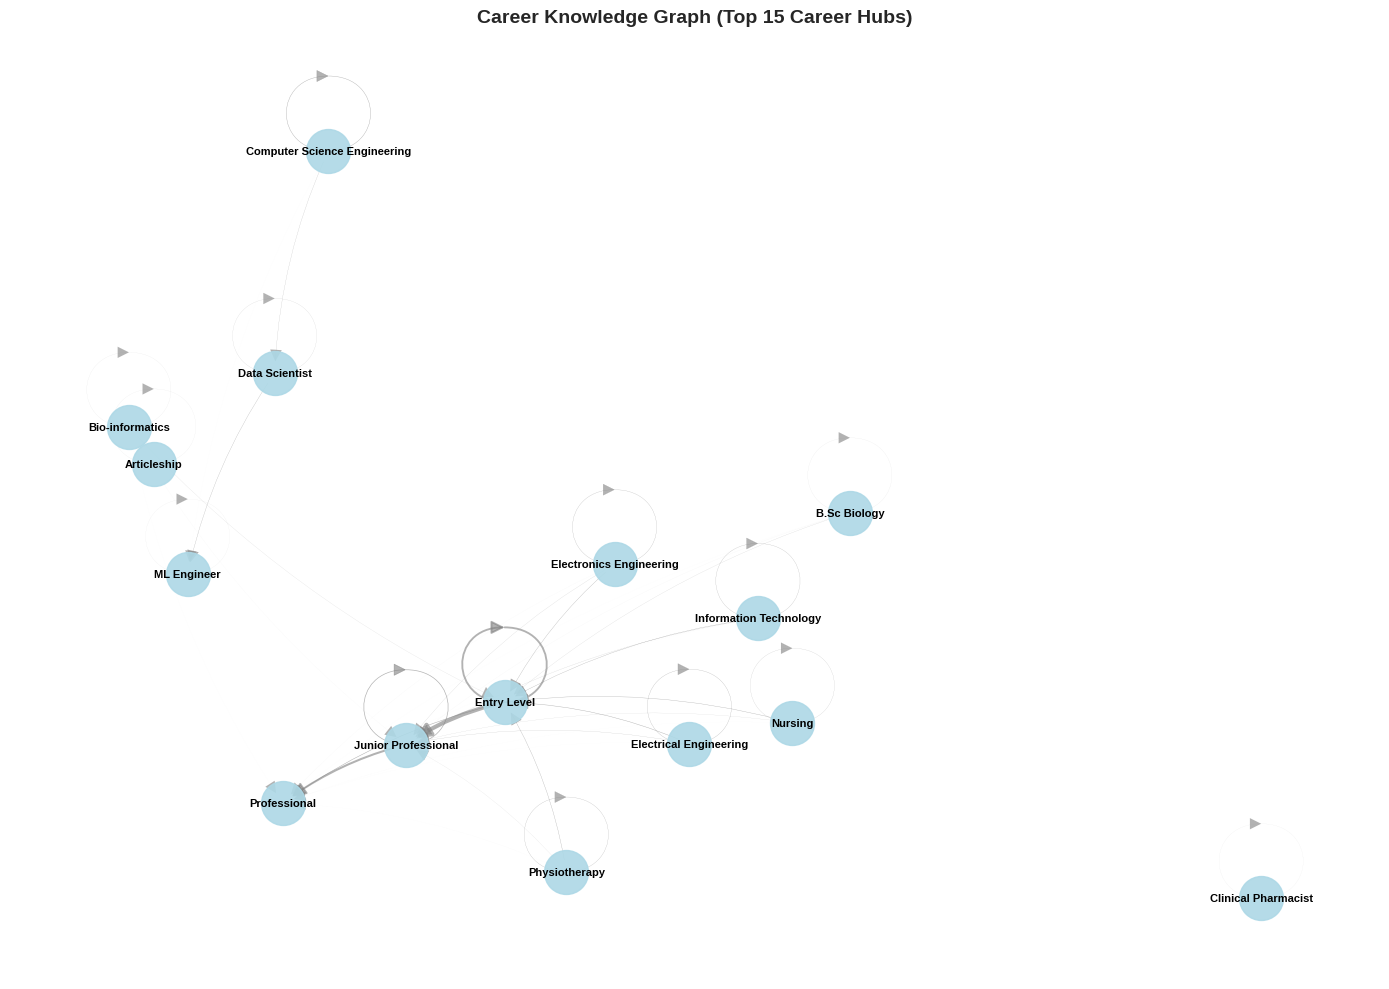

In [4]:
# ═══════════════════════════════════════════════════════════════════════════════
# SECTION 2: BUILD KNOWLEDGE GRAPH
# ═══════════════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("SECTION 2: BUILDING KNOWLEDGE GRAPH")
print("="*80)

G = nx.DiGraph()

# Add nodes
for career in all_careers:
    G.add_node(career)

# Add edges from trajectories
for idx, row in df.iterrows():
    trajectory = [row['career_path_year1'], row['career_year2'], 
                 row['career_year3'], row['career_year4'], row['career_year5']]
    
    # Remove consecutive duplicates
    unique_trajectory = [trajectory[0]]
    for i in range(1, len(trajectory)):
        if trajectory[i] != trajectory[-1]:
            unique_trajectory.append(trajectory[i])
    
    # Add edges
    for i in range(len(unique_trajectory) - 1):
        if G.has_edge(unique_trajectory[i], unique_trajectory[i+1]):
            G[unique_trajectory[i]][unique_trajectory[i+1]]['weight'] += 1
        else:
            G.add_edge(unique_trajectory[i], unique_trajectory[i+1], weight=1)

# Calculate transition probabilities
for u, v in G.edges():
    total_weight = sum(G[u][n]['weight'] for n in G.successors(u))
    G[u][v]['probability'] = G[u][v]['weight'] / total_weight if total_weight > 0 else 0.5

print(f"✓ Knowledge graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# Visualize top career hubs
degree_sequence = sorted(G.degree(), key=lambda x: x[1], reverse=True)
print(f"\nTop 10 Career Hubs:")
for career, degree in degree_sequence[:10]:
    print(f"  {career}: {degree} connections")

# Visualize subgraph
top_careers = [c[0] for c in degree_sequence[:15]]
G_sub = G.subgraph(top_careers).copy()

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G_sub, k=2, iterations=50, seed=42)
nx.draw_networkx_nodes(G_sub, pos, node_color='lightblue', node_size=1000, alpha=0.9)

edges = G_sub.edges()
weights = [G_sub[u][v]['weight'] for u, v in edges]
max_weight = max(weights) if weights else 1
widths = [3 * w / max_weight for w in weights]

nx.draw_networkx_edges(G_sub, pos, width=widths, edge_color='gray', alpha=0.6,
                       arrows=True, arrowsize=20, connectionstyle='arc3,rad=0.1')
nx.draw_networkx_labels(G_sub, pos, font_size=8, font_weight='bold')

plt.title("Career Knowledge Graph (Top 15 Career Hubs)", fontsize=14, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.savefig('knowledge_graph_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

In [5]:
# ═══════════════════════════════════════════════════════════════════════════════
# SECTION 3: CAREER ENVIRONMENT (RL ENVIRONMENT)
# ═══════════════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("SECTION 3: IMPLEMENTING CAREER ENVIRONMENT")
print("="*80)

class CareerEnvironment:
    def __init__(self, df, graph, career_to_id, id_to_career, max_steps=5):
        self.df = df
        self.graph = graph
        self.career_to_id = career_to_id
        self.id_to_career = id_to_career
        self.max_steps = max_steps
        self.num_careers = len(career_to_id)
        self.reset()
    
    def reset(self):
        """FIX: Return exactly (state, info)"""
        self.current_student_idx = np.random.randint(0, len(self.df))
        self.current_student = self.df.iloc[self.current_student_idx]
        self.trajectory = [
            self.current_student['career_path_year1'],
            self.current_student['career_year2'],
            self.current_student['career_year3'],
            self.current_student['career_year4'],
            self.current_student['career_year5']
        ]
        self.current_career_idx = 0
        self.step_count = 0
        
        state = self._get_state()
        info = {}
        return state, info
    
    def _get_state(self):
        """Return state vector of shape (38,)"""
        return create_state_vector(self.current_student)
    
    def _get_valid_actions(self):
        """Get valid next career transitions"""
        current_career = self.trajectory[self.current_career_idx]
        if current_career in self.graph:
            successors = list(self.graph.successors(current_career))
            return [self.career_to_id[c] for c in successors]
        else:
            return list(range(self.num_careers))
    
    def is_terminal(self):
        """Check if episode is finished"""
        return (self.step_count >= self.max_steps or 
                self.current_career_idx >= len(self.trajectory) - 1)
    
    def compute_reward(self, action):
        """Compute reward for taking action"""
        current_career = self.trajectory[self.current_career_idx]
        next_career = self.id_to_career[action]
        reward = 0.0
        
        # Trajectory alignment (40%)
        if self.graph.has_edge(current_career, next_career):
            prob = self.graph[current_career][next_career].get('probability', 0.5)
            reward += 0.4 * prob
        else:
            reward -= 0.2
        
        # Academic fit (30%)
        stream = self.current_student['12th_stream']
        academic_reward = self._get_academic_fit(stream, next_career)
        reward += 0.3 * academic_reward
        
        # Progress score (20%)
        progress_reward = self._get_progress_score(current_career, next_career)
        reward += 0.2 * progress_reward
        
        # Diversity (10%)
        diversity_reward = 0.5 if next_career != current_career else -0.3
        reward += 0.1 * diversity_reward
        
        return reward
    
    def _get_academic_fit(self, stream, career):
        """Calculate academic fit score"""
        engineering = ['Computer Science', 'Mechanical', 'Electrical', 'Data Science', 'AI/ML']
        medical = ['MBBS', 'BDS', 'Pharmacy', 'Nursing', 'Physiotherapy']
        commerce = ['B.Com', 'BBA', 'CA', 'CS', 'CMA']
        
        if stream in ['Science-PCM', 'Science-PCMB']:
            if any(e in career for e in engineering):
                return 1.0
            elif any(m in career for m in medical):
                return 0.5
            return 0.3
        elif stream == 'Science-PCB':
            if any(m in career for m in medical):
                return 1.0
            return 0.3
        elif stream == 'Commerce':
            if any(c in career for c in commerce):
                return 1.0
            return 0.3
        else:
            return 0.5
    
    def _get_progress_score(self, current, next_career):
        """Calculate career progression score"""
        keywords = {'Senior': 2, 'Lead': 1.5, 'Manager': 1.5, 'Director': 2}
        current_score = sum(v for k, v in keywords.items() if k in current)
        next_score = sum(v for k, v in keywords.items() if k in next_career)
        
        progress = min(next_score - current_score, 2.0)
        return 1.0 if next_score > current_score else -0.2
    
    def step(self, action):
        """FIX: Return exactly (state, reward, done, info)"""
        reward = self.compute_reward(action)
        self.current_career_idx += 1
        self.step_count += 1
        done = self.is_terminal()
        
        # Get next state
        if not done:
            state = self._get_state()
        else:
            #state = np.zeros_like(self._get_state())
            state = np.zeros(38, dtype=np.float32)  # Always correct shape
        
        info = {"career": self.id_to_career[action]}
        
        return state, reward, done, info  # ✓ EXACTLY 4 values


env = CareerEnvironment(df_encoded, G, career_to_id, id_to_career, max_steps=5)
print(f"✓ Environment initialized")
print(f"  State dimension: {env._get_state().shape}")
print(f"  Number of careers (actions): {env.num_careers}")


SECTION 3: IMPLEMENTING CAREER ENVIRONMENT
✓ Environment initialized
  State dimension: (38,)
  Number of careers (actions): 72


In [6]:
# ═══════════════════════════════════════════════════════════════════════════════
# SECTION 4: DUELING DQN ARCHITECTURE
# ═══════════════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("SECTION 4: IMPLEMENTING DUELING DQN")
print("="*80)

class DuelingDQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DuelingDQN, self).__init__()
        
        # Shared feature layers with BatchNorm
        self.feature_layers = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
        )
        
        # Value stream
        self.value_stream = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
        # Advantage stream
        self.advantage_stream = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )
        
        self.action_dim = action_dim
    
    def forward(self, state):
        features = self.feature_layers(state)
        value = self.value_stream(features)
        advantages = self.advantage_stream(features)
        
        # Dueling aggregation: Q = V + (A - mean(A))
        q_values = value + (advantages - advantages.mean(dim=1, keepdim=True))
        return q_values


class ReplayBuffer:
    def __init__(self, capacity=50000):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        states = torch.FloatTensor(np.array(states)).to(device)
        actions = torch.LongTensor(np.array(actions)).to(device)
        rewards = torch.FloatTensor(np.array(rewards)).to(device)
        next_states = torch.FloatTensor(np.array(next_states)).to(device)
        dones = torch.FloatTensor(np.array(dones)).to(device)
        
        return states, actions, rewards, next_states, dones
    
    def __len__(self):
        return len(self.buffer)


class CareerPathDDQNAgent:
    def __init__(self, state_dim, action_dim, env, learning_rate=1e-3):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.device = device
        self.env = env
        # Networks
        self.policy_net = DuelingDQN(state_dim, action_dim).to(device)
        self.target_net = DuelingDQN(state_dim, action_dim).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        
        # Optimizer
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)
        
        # Replay buffer
        self.replay_buffer = deque(maxlen=10000)
        self.batch_size = 64
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        
        self.update_counter = 0
        self.target_update_freq = 1000
        
        self.training_history = {'episode_rewards': [], 'episode_lengths': [], 
                                 'losses': [], 'epsilon_values': []}
    
    def select_action(self, state, valid_actions, training=True):
        """
        FIX: Set model to eval() mode before inference to handle BatchNorm properly
        """
        # Epsilon-greedy exploration
        if training and np.random.random() < self.epsilon:
            return random.choice(valid_actions) if valid_actions else 0
        
        # Set to eval mode for inference (BatchNorm uses running statistics)
        self.policy_net.eval()
        
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            q_values = self.policy_net(state_tensor).squeeze()
            
            # Mask invalid actions
            q_values[torch.tensor([i not in valid_actions for i in range(self.action_dim)], 
                                  device=self.device)] = -float('inf')
            
            action = torch.argmax(q_values).item()
        
        # Set back to train mode for learning
        if training:
            self.policy_net.train()
        
        return action

    def store_transition(self, state, action, reward, next_state, done):
        self.replay_buffer.append((state, action, reward, next_state, done))
    
    def train_step(self):
        """
        Train on a batch from replay buffer
        """
        if len(self.replay_buffer) < self.batch_size:
            return
        
        # Set to train mode for gradient computation
        self.policy_net.train()
        
        # Sample batch
        batch = random.sample(self.replay_buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        states = torch.FloatTensor(np.array(states)).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(np.array(next_states)).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)
        
        # Current Q-values from policy network
        current_q = self.policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # Target Q-values from target network
        with torch.no_grad():
            # Set target_net to eval mode for inference
            self.target_net.eval()
            next_q = self.target_net(next_states).max(1)[0]
            target_q = rewards + (1 - dones) * self.gamma * next_q
        
        # Compute loss and update
        loss = nn.MSELoss()(current_q, target_q)
        
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), max_norm=1.0)
        self.optimizer.step()
        
        # Update target network periodically
        self.update_counter += 1
        if self.update_counter % self.target_update_freq == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
            self.target_net.eval()  # Set target net to eval mode
        
        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        
        return loss.item()
    
    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())
    
    def decay_epsilon(self):
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)
    
    def save_model(self, filepath):
        checkpoint = {
            'policy_net': self.policy_net.state_dict(),
            'target_net': self.target_net.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'epsilon': self.epsilon,
            'training_history': self.training_history
        }
        torch.save(checkpoint, filepath)
        print(f"✓ Model saved to {filepath}")

# Initialize agent
agent = CareerPathDDQNAgent(
    state_dim=env._get_state().shape[0],
    action_dim=env.num_careers,
    env=env,
    learning_rate=1e-4
)

print(f"✓ Agent initialized")
print(f"  Input: {agent.state_dim} dimensions")
print(f"  Output: {agent.action_dim} actions")


SECTION 4: IMPLEMENTING DUELING DQN
✓ Agent initialized
  Input: 38 dimensions
  Output: 72 actions


In [7]:
# ═══════════════════════════════════════════════════════════════════════════════
# SECTION 5: TRAINING
# ═══════════════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("SECTION 5: TRAINING THE DDQN AGENT")
print("="*80)

def train_agent(agent, env, num_episodes=500, eval_freq=10):
    """Fixed training with proper history tracking"""
    
    # Initialize training history
    agent.training_history = {
        'episode_rewards': [],
        'episode_lengths': [],
        'losses': [],
        'epsilon_values': []
    }
    
    for episode in range(num_episodes):
        # ✓ FIX: Correctly unpack reset()
        state, info = env.reset()
        episode_reward = 0
        episode_length = 0
        episode_losses = []
        
        while not env.is_terminal():
            valid_actions = env._get_valid_actions()
            
            # Select action (training mode - can explore)
            action = agent.select_action(state, valid_actions, training=True)
            
            # ✓ FIX: Correctly unpack step()
            next_state, reward, done, info = env.step(action)
            
            # Store transition
            agent.store_transition(state, action, reward, next_state, done)
            
            # Train on batch
            loss = agent.train_step()
            if loss is not None:
                episode_losses.append(loss)
                agent.training_history['losses'].append(loss)
            
            episode_reward += reward
            episode_length += 1
            state = next_state
        
        # Store episode metrics
        agent.training_history['episode_rewards'].append(episode_reward)
        agent.training_history['episode_lengths'].append(episode_length)
        agent.training_history['epsilon_values'].append(agent.epsilon)
        
        # Evaluation and logging
        if (episode + 1) % eval_freq == 0:
            avg_reward = np.mean(agent.training_history['episode_rewards'][-eval_freq:])
            avg_length = np.mean(agent.training_history['episode_lengths'][-eval_freq:])
            avg_loss = (np.mean(agent.training_history['losses'][-min(eval_freq*64, len(agent.training_history['losses'])):]) 
                       if agent.training_history['losses'] else 0)
            
            print(f"Episode {episode+1}/{num_episodes} | "
                  f"Avg Reward: {avg_reward:.2f} | "
                  f"Avg Length: {avg_length:.1f} | "
                  f"Avg Loss: {avg_loss:.4f} | "
                  f"Epsilon: {agent.epsilon:.4f}")
    
    return agent
            

print("Starting training...")
agent = train_agent(agent, env, num_episodes=500, eval_freq=10)


SECTION 5: TRAINING THE DDQN AGENT
Starting training...
Episode 10/500 | Avg Reward: 0.98 | Avg Length: 4.0 | Avg Loss: 0.0000 | Epsilon: 1.0000
Episode 20/500 | Avg Reward: 0.74 | Avg Length: 4.0 | Avg Loss: 0.2576 | Epsilon: 0.9183
Episode 30/500 | Avg Reward: 0.72 | Avg Length: 4.0 | Avg Loss: 0.1177 | Epsilon: 0.7515
Episode 40/500 | Avg Reward: 1.04 | Avg Length: 4.0 | Avg Loss: 0.0824 | Epsilon: 0.6149
Episode 50/500 | Avg Reward: 0.84 | Avg Length: 4.0 | Avg Loss: 0.0657 | Epsilon: 0.5032
Episode 60/500 | Avg Reward: 0.84 | Avg Length: 4.0 | Avg Loss: 0.0556 | Epsilon: 0.4118
Episode 70/500 | Avg Reward: 0.89 | Avg Length: 4.0 | Avg Loss: 0.0486 | Epsilon: 0.3370
Episode 80/500 | Avg Reward: 0.75 | Avg Length: 4.0 | Avg Loss: 0.0436 | Epsilon: 0.2758
Episode 90/500 | Avg Reward: 0.72 | Avg Length: 4.0 | Avg Loss: 0.0399 | Epsilon: 0.2257
Episode 100/500 | Avg Reward: 0.87 | Avg Length: 4.0 | Avg Loss: 0.0370 | Epsilon: 0.1847
Episode 110/500 | Avg Reward: 0.93 | Avg Length: 4.0

In [8]:
# # ═══════════════════════════════════════════════════════════════════════════════
# # SECTION 6: VISUALIZATION
# # ═══════════════════════════════════════════════════════════════════════════════

# print("\n" + "="*80)
# print("SECTION 6: TRAINING VISUALIZATION")
# print("="*80)

# fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# # Rewards
# axes[0, 0].plot(agent.training_history['episode_rewards'], alpha=0.6)
# axes[0, 0].plot(pd.Series(agent.training_history['episode_rewards']).rolling(10).mean(),
#                linewidth=2, color='red', label='MA(10)')
# axes[0, 0].set_title('Episode Rewards')
# axes[0, 0].set_xlabel('Episode')
# axes[0, 0].legend()
# axes[0, 0].grid(True, alpha=0.3)

# # Loss
# if agent.training_history['losses']:
#     axes[0, 1].plot(agent.training_history['losses'], alpha=0.6)
#     axes[0, 1].plot(pd.Series(agent.training_history['losses']).rolling(50).mean(),
#                    linewidth=2, color='red', label='MA(50)')
#     axes[0, 1].set_title('Training Loss')
#     axes[0, 1].set_xlabel('Step')
#     axes[0, 1].set_yscale('log')
#     axes[0, 1].legend()
#     axes[0, 1].grid(True, alpha=0.3)

# # Epsilon
# axes[1, 0].plot(agent.training_history['epsilon_values'])
# axes[1, 0].set_title('Epsilon Decay')
# axes[1, 0].set_xlabel('Episode')
# axes[1, 0].grid(True, alpha=0.3)

# axes[1, 1].hist(agent.training_history['episode_rewards'], bins=30, alpha=0.7)
# axes[1, 1].set_title('Reward Distribution')
# axes[1, 1].set_xlabel('Reward')
# axes[1, 1].set_ylabel('Frequency')

# plt.tight_layout()
# plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
# plt.show()

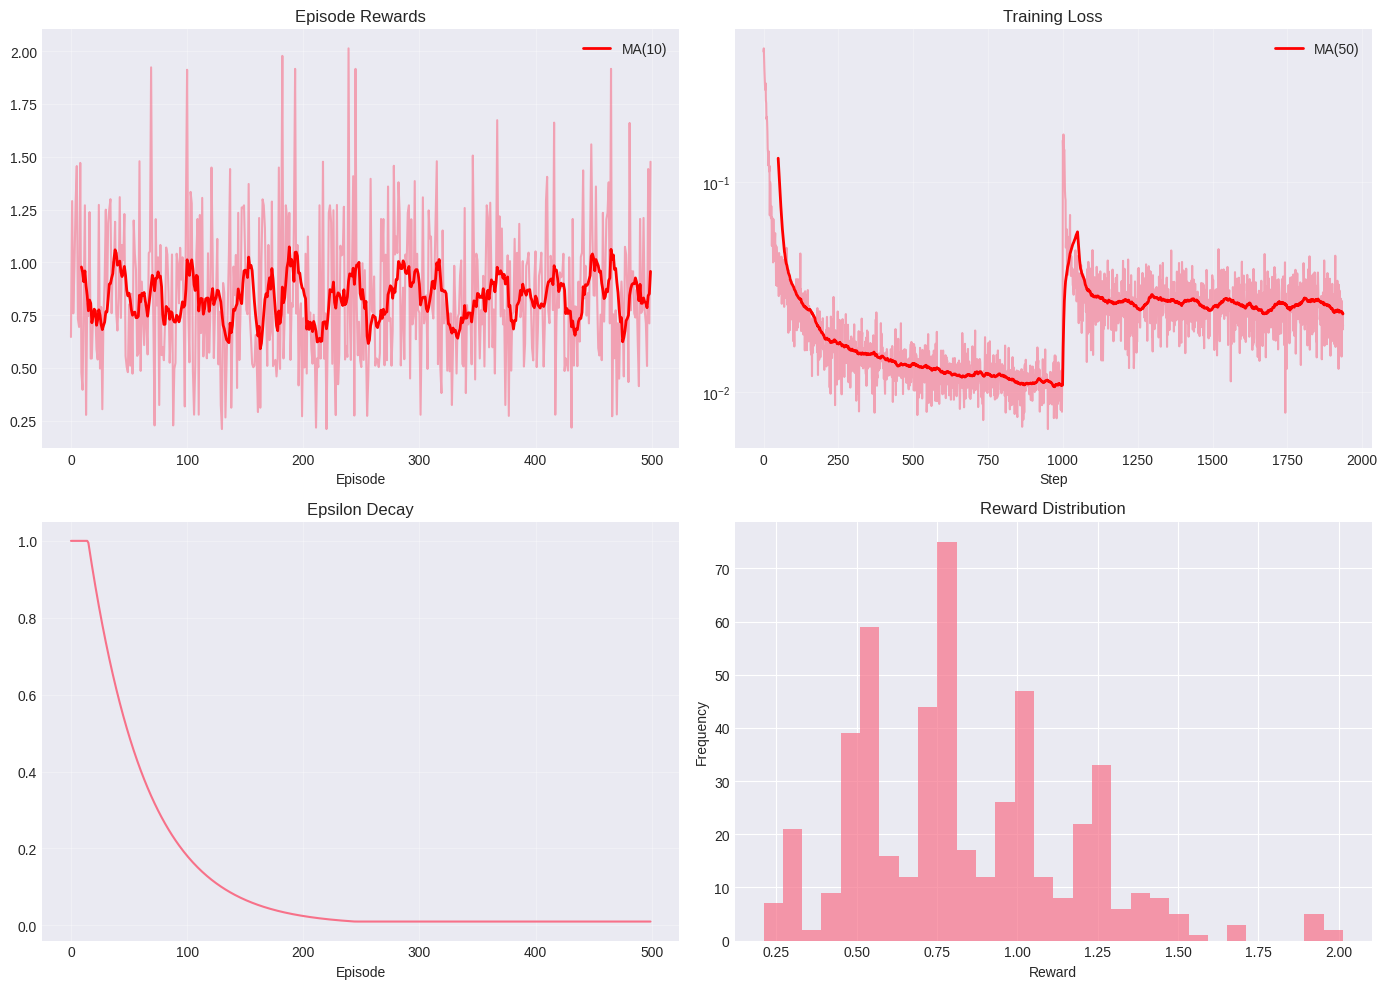

In [9]:
def plot_training_results(agent):
    """FIX: Plot training curves using agent's stored history"""
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Get data from agent's training history
    rewards = agent.training_history['episode_rewards']
    losses = agent.training_history['losses']
    epsilon_vals = agent.training_history['epsilon_values']
    
    # Episode Rewards
    axes[0, 0].plot(rewards, alpha=0.6)
    axes[0, 0].plot(pd.Series(rewards).rolling(10).mean(), 
                   linewidth=2, color='red', label='MA(10)')
    axes[0, 0].set_title('Episode Rewards')
    axes[0, 0].set_xlabel('Episode')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Training Loss
    axes[0, 1].plot(losses, alpha=0.6)
    axes[0, 1].plot(pd.Series(losses).rolling(50).mean(),
                   linewidth=2, color='red', label='MA(50)')
    axes[0, 1].set_title('Training Loss')
    axes[0, 1].set_xlabel('Step')
    axes[0, 1].set_yscale('log')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Epsilon Decay
    axes[1, 0].plot(epsilon_vals)
    axes[1, 0].set_title('Epsilon Decay')
    axes[1, 0].set_xlabel('Episode')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Reward Distribution
    axes[1, 1].hist(rewards, bins=30, alpha=0.7)
    axes[1, 1].set_title('Reward Distribution')
    axes[1, 1].set_xlabel('Reward')
    axes[1, 1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.savefig('training_curves_fixed.png', dpi=150, bbox_inches='tight')
    plt.show()

plot_training_results(agent)

In [11]:
# ═══════════════════════════════════════════════════════════════════════════════
# SECTION 7: EVALUATION
# ═══════════════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("SECTION 7: MODEL EVALUATION")
print("="*80)


def evaluate_model(agent, env, num_eval=100):
    """FIX: Properly handle state shapes and return values"""
    
    path_validity = []
    rewards = []
    
    for _ in range(num_eval):
        try:
            # ✓ FIX: Correctly unpack reset()
            state, info = env.reset()
            
            # ✓ CHECK: Verify state is valid
            if state is None or len(state) == 0:
                print("WARNING: Invalid state from env.reset()")
                continue
            
            path = [env.trajectory[0]]
            episode_reward = 0
            done = False
            
            while not done:
                valid = env._get_valid_actions()
                
                # ✓ FIX: Use eval mode for selection
                action = agent.select_action(state, valid, training=False)
                
                # ✓ FIX: Correctly unpack step()
                next_state, reward, done, info = env.step(action)
                
                # Validate next state
                if next_state is not None and len(next_state) > 0:
                    path.append(info.get("career", "Unknown"))
                    episode_reward += reward
                    state = next_state
                else:
                    break
            
            # Calculate path validity
            valid_edges = sum(1 for i in range(len(path)-1) 
                            if agent.env.graph.has_edge(path[i], path[i+1]))
            validity = (valid_edges / (len(path) - 1)) * 100 if len(path) > 1 else 0
            
            path_validity.append(validity)
            rewards.append(episode_reward)
            
        except Exception as e:
            print(f"Error in evaluation: {e}")
            continue
    
    # Return metrics dict
    metrics = {
        'avg_reward': np.mean(rewards) if rewards else 0,
        'std_reward': np.std(rewards) if rewards else 0,
        'path_validity': np.mean(path_validity) if path_validity else 0,
        'avg_path_length': 5  # Your max_steps
    }
    
    return metrics


# Evaluation
metrics = evaluate_model(agent, env, num_eval=100)
print(f"\nEvaluation Metrics:")
print(f"Average Reward: {metrics['avg_reward']:.3f}")
print(f"Path Validity: {metrics['path_validity']:.1f}%")
print(f"Avg Path Length: {metrics['avg_path_length']:.1f}")

# Save metrics
with open('evaluation_metrics.json', 'w') as f:
    json.dump({k: float(v) for k, v in metrics.items()}, f, indent=2)


SECTION 7: MODEL EVALUATION

Evaluation Metrics:
Average Reward: 0.850
Path Validity: 63.2%
Avg Path Length: 5.0


In [13]:
# ═══════════════════════════════════════════════════════════════════════════════
# SECTION 8: SAVE ARTIFACTS
# ═══════════════════════════════════════════════════════════════════════════════

print("\n" + "="*80)
print("SECTION 8: SAVING MODEL & ARTIFACTS")
print("="*80)

# Save model
agent.save_model('best_career_model.pth')

# Save artifacts
artifacts = {
    'career_to_id': career_to_id,
    'id_to_career': id_to_career,
    'categorical_features': categorical_features,
    'numerical_features': numerical_features,
    'scaler_params': {
        'min': scaler.data_min_.tolist(),
        'max': scaler.data_max_.tolist(),
    },
    'model_config': {
        'state_dim': agent.state_dim,
        'action_dim': agent.action_dim,
        'gamma': agent.gamma,
    },
    'metrics': metrics
}

with open('model_artifacts.pkl', 'wb') as f:
    pickle.dump(artifacts, f)

# Save knowledge graph
#nx.write_gpickle(G, 'knowledge_graph.gpickle')
with open('knowledge_graph.gpickle', 'wb') as f:
    pickle.dump(G, f)

print("✓ Model saved: best_career_model.pth")
print("✓ Artifacts saved: model_artifacts.pkl")
print("✓ Graph saved: knowledge_graph.gpickle")

print("\n" + "="*80)
print("✓ TRAINING COMPLETE!")
print("="*80)
print("""
Next Steps:
1. Download all generated files
2. Deploy with Streamlit locally
3. Test recommendations with questionnaire input
""")


SECTION 8: SAVING MODEL & ARTIFACTS
✓ Model saved to best_career_model.pth
✓ Model saved: best_career_model.pth
✓ Artifacts saved: model_artifacts.pkl
✓ Graph saved: knowledge_graph.gpickle

✓ TRAINING COMPLETE!

Next Steps:
1. Download all generated files
2. Deploy with Streamlit locally
3. Test recommendations with questionnaire input

